In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Least squares optimization

Many optimization problems involve minimization of a sum of squared residuals. We will take a look at finding the derivatives for least squares minimization.

In least squares problems, we usually have $m$ labeled observations $(x_i, y_i)$. We have a model that will predict $y_i$ given $x_i$ for some parameters $\beta$, $f(x) = X\beta$. We want to minimize the sum (or average) of squared residuals $r(x_i) = y_i - f(x_i)$. For example, the objective function is usually taken to be 

$$
\frac{1}{2} \sum{r(x_i)^2}
$$

As a concrete example, suppose we want to fit a quadratic function to some observed data. We have

$$
f(x) = \beta_0 + \beta_1 x + \beta_2 x^2
$$

We want to minimize the objective function

$$
L = \frac{1}{2} \sum_{i=1}^m (y_i - f(x_i))^2
$$

Taking derivatives with respect to $\beta$, we get

$$
\frac{dL}{d\beta} = 
\begin{bmatrix}
\sum_{i=1}^m f(x_i) - y_i \\
\sum_{i=1}^m x_i f(x_i) - y_i \\
\sum_{i=1}^m x_i^2 f(x_i) - y_i
\end{bmatrix}
$$




## Working with matrices

Writing the above system as a matrix, we have $f(x) = X\beta$, with

$$ 
X = \begin{bmatrix}
1 & x_1 & x_1^2 \\
1 & x_2 & x_2^2 \\
\vdots & \vdots & \vdots \\
1 & x_m & x_m^2 
\end{bmatrix}
$$

and 

$$
\beta = \begin{bmatrix}
\beta_0 \\
\beta_1 \\
\beta_2
\end{bmatrix}
$$

We want to find the derivative of $\Vert y - X\beta \Vert^2$, so

$$
\Vert y - X\beta \Vert^2 \\
= (y - X\beta)^T(y - X\beta) \\
= (y^T - \beta^TX^T)(y - X\beta) \\
= y^Ty - \beta^TX^Ty -y^TX\beta + \beta^TX^TX\beta
$$

Taking derivatives with respect to $\beta^T$ (we do this because the gradient is traditionally a row vector, and we want it as a column vector here), we get (after multiplying by $1/2$ for the residue function)

$$
\frac{dL}{d\beta^T} =  X^TX\beta - X^Ty
$$

For example, if we are doing gradient descent, the update equation is

$$
\beta_{k+1} = \beta_k + \alpha (X^TX\beta - X^Ty)
$$

Note that if we set the derivative to zero and solve, we get

$$
X^TX\beta - X^Ty = 0
$$

and the normal equations

$$
\beta = (X^TX)^{-1}X^Ty
$$

For large $X$, solving the normal equations can be more expensive than simpler gradient descent. Note that the Levenberg-Marquadt algorithm is often used to optimize least squares problems.

## Example

You are given the following set of data to fit a quadratic polynomial to:

```python
x = np.arange(10)
y = np.array([  1.58873597,   7.55101533,  10.71372171,   7.90123225,
                -2.05877605, -12.40257359, -28.64568712, -46.39822281,
                -68.15488905, -97.16032044])
```

Find the least squares solution using gradient descent.

In [3]:
x = np.arange(10)
y = np.array([  1.58873597,   7.55101533,  10.71372171,   7.90123225,
                -2.05877605, -12.40257359, -28.64568712, -46.39822281,
                -68.15488905, -97.16032044])

In [4]:
def f(x, y, b):
    return (b[0] + b[1]*x + b[2]*x**2 - y)

def res(x, y, b):
    return sum(f(x,y, b)*f(x, y, b))

# Elementary form of gradient
def grad(x, y, b):
    n = len(x)
    return np.array([
            sum(f(x, y, b)),
            sum(x*f(x, y, b)),
            sum(x**2*f(x, y, b))
    ])

# Matrix form of gradient
def grad_m(X, y, b):
    return X.T@X@b- X.T@y

In [5]:
grad(x, y, np.zeros(3))

array([  227.0657638 ,  1933.9094954 , 15758.14427298])

In [6]:
X = np.c_[np.ones(len(x)), x, x**2]
grad_m(X, y, np.zeros(3))

array([  227.0657638 ,  1933.9094954 , 15758.14427298])

In [7]:
from scipy.linalg import solve

beta1 = solve(X.T@X, X.T@y)
beta1

array([ 2.55079998,  7.31478229, -2.04118936])

In [8]:
max_iter = 10000

In [9]:
a = 0.0001 # learning rate
beta2 = np.zeros(3)
for i in range(max_iter):
    beta2 -= a * grad(x, y, beta2)
beta2

array([ 2.73391723,  7.23152392, -2.03359658])

In [10]:
a = 0.0001 # learning rate
beta3 = np.zeros(3)
for i in range(max_iter):
    beta3 -= a * grad_m(X, y, beta3)
beta3

array([ 2.73391723,  7.23152392, -2.03359658])

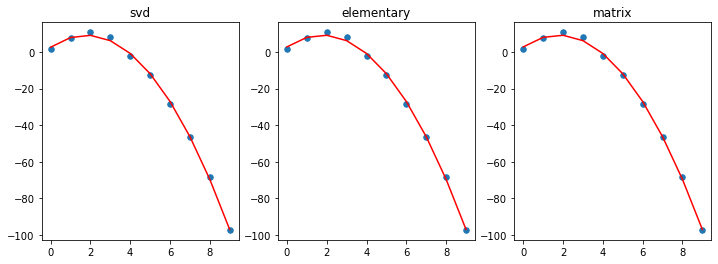

In [11]:
titles = ['svd', 'elementary', 'matrix']

plt.figure(figsize=(12,4))
for i, beta in enumerate([beta1, beta2, beta3], 1):
    plt.subplot(1, 3, i)
    plt.scatter(x, y, s=30)
    plt.plot(x, beta[0] + beta[1]*x + beta[2]*x**2, color='red')
    plt.title(titles[i-1])

### Curve fitting and least squares optimization

As shown above, least squares optimization is the technique most associated with curve fitting. For convenience, `scipy.optimize` provides a `curve_fit` function that uses Levenberg-Marquadt for minimization.

In [12]:
from scipy.optimize import curve_fit 

In [13]:
def logistic4(x, a, b, c, d):
    """The four paramter logistic function is often used to fit dose-response relationships."""
    return ((a-d)/(1.0+((x/c)**b))) + d

In [14]:
nobs = 24
xdata = np.linspace(0.5, 3.5, nobs)
ptrue = [10, 3, 1.5, 12]
ydata = logistic4(xdata, *ptrue) + 0.5*np.random.random(nobs)

In [15]:
popt, pcov = curve_fit(logistic4, xdata, ydata) 

In [16]:
perr = yerr=np.sqrt(np.diag(pcov))
print('Param\tTrue\tEstim (+/- 1 SD)')
for p, pt, po, pe  in zip('abcd', ptrue, popt, perr):
    print('%s\t%5.2f\t%5.2f (+/-%5.2f)' % (p, pt, po, pe))

Param	True	Estim (+/- 1 SD)
a	10.00	10.39 (+/- 0.08)
b	 3.00	 4.86 (+/- 0.83)
c	 1.50	 1.46 (+/- 0.05)
d	12.00	12.08 (+/- 0.06)


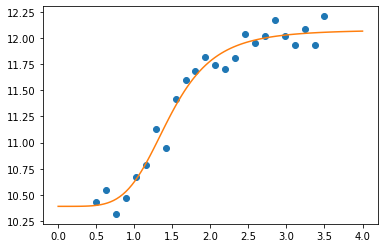

In [17]:
x = np.linspace(0, 4, 100)
y = logistic4(x, *popt)
plt.plot(xdata, ydata, 'o')
plt.plot(x, y)
pass